# **ICS5110 Notebook**

View the web page for this project [here](https://mkenely.com/ics5110).

- [Feature Reference](https://mkenely.com/ics5110/features)
- [Feature Distributions](https://mkenely.com/ics5110/distributions)
- [Correlation Matrix](https://mkenely.com/ics5110/correlation_matrix)
- [Feature vs G3 Scatter Plots](https://mkenely.com/ics5110/scatter_plots)


### **Imports**

In [ ]:
import os
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pickle

from gradio_implementations import pca_gradio
from gradio_implementations import ensemble_gradio
from gradio_implementations import kmc_gradio
from gradio_implementations import lr_gradio

import matplotlib.pyplot as plt

### **Data**

In [2]:
portugese_df = pd.read_csv('./data/Portuguese.csv')

le = LabelEncoder()
encoding_mappings = {}

for column in portugese_df.columns:
    if portugese_df[column].dtype == 'object':
        portugese_df[column] = le.fit_transform(portugese_df[column])
        encoding_mappings[column] = {index: label for index, label in enumerate(le.classes_)}

X = portugese_df.drop('G3', axis=1)
X = X.drop('G1', axis=1)
X = X.drop('G2', axis=1)

y = portugese_df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### **Models**

#### **K-Means Clustering (Karl)**

**Imports**

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

**Data**

In [21]:
#We must prepare the data first. K-means is not ideal for categorical data so we'll focus on the numerical.
X = portugese_df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'health', 'Dalc', 'Walc', 'G1', 
        'G2', 'G3', 'goout', 'freetime', 'absences']]
#Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

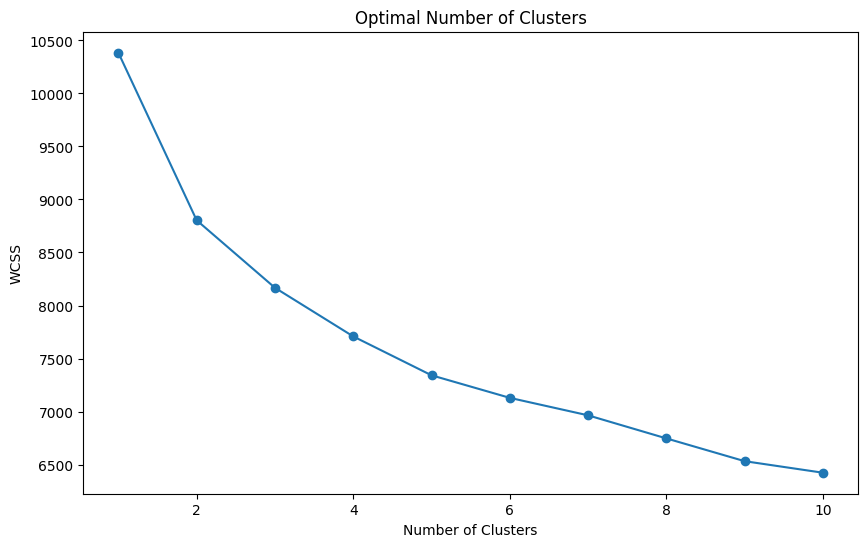

In [22]:
#Before we perform K-means, we must decide how many clusters we're going to use.
wcss = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
#Plotting elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
#From the elbow plot we can determine that the ideal no. of clusters is 2.
optimal_clusters = 2
cluster_df = portugese_df.copy()
#K-Means
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_df['Cluster'] = kmeans.labels_

In [24]:
#Displaying the dataset again with the cluster labels
print(cluster_df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'health', 'Dalc', 'Walc', 'G1', 
          'G2', 'G3', 'goout', 'freetime', 'absences', 'Cluster']].head())
print('\n')
#Analyzing the centroid values of each cluster
cluster_analysis = cluster_df.groupby('Cluster')[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 
                                          'health', 'Dalc', 'Walc', 'G1', 'G2', 'G3', 'goout', 'freetime', 
                                          'absences']].mean()
print(cluster_analysis)

   age  Medu  Fedu  traveltime  studytime  failures  famrel  health  Dalc  \
0   18     4     4           2          2         0       4       3     1   
1   17     1     1           1          2         0       5       3     1   
2   15     1     1           1          2         0       4       3     2   
3   15     4     2           1          3         0       3       5     1   
4   16     3     3           1          2         0       4       5     1   

   Walc  G1  G2  G3  goout  freetime  absences  Cluster  
0     1   0  11  11      4         3         4        1  
1     1   9  11  11      3         3         2        1  
2     3  12  13  12      2         3         6        0  
3     1  14  14  14      2         2         0        0  
4     2  11  13  13      2         3         0        0  


               age      Medu      Fedu  traveltime  studytime  failures  \
Cluster                                                                   
0        16.502717  2.877717  2.61413

In [25]:
# Get a sample individual
sample = portugese_df[['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'health', 'Dalc', 'Walc', 'G1', 
          'G2', 'G3', 'goout', 'freetime', 'absences']].sample(25)

# predict the cluster
sample_cluster = kmeans.predict(sample)[0]

print(f"Sample individual belongs to cluster {sample_cluster}")

# Top 5 most similar individuals
top_5 = cluster_df[cluster_df['Cluster'] == sample_cluster].sort_values('G3', ascending=False).head(5)


print(top_5)

Sample individual belongs to cluster 0
     school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
338       0    0   17        0        1        1     3     1     3     2  ...   
636       1    1   18        1        0        1     4     4     4     4  ...   
594       1    0   18        1        0        1     4     4     4     4  ...   
596       1    0   17        1        0        1     4     2     2     2  ...   
509       1    0   16        0        1        1     1     1     0     2  ...   

     freetime  goout  Dalc  Walc  health  absences  G1  G2  G3  Cluster  
338         1      2     1     1       3         0  18  19  19        0  
636         2      4     1     4       2         4  17  18  19        0  
594         3      5     1     2       1         0  18  18  18        0  
596         3      3     1     2       4         0  17  18  18        0  
509         3      2     1     1       1         0  16  17  18        0  

[5 rows x 34 columns]


c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


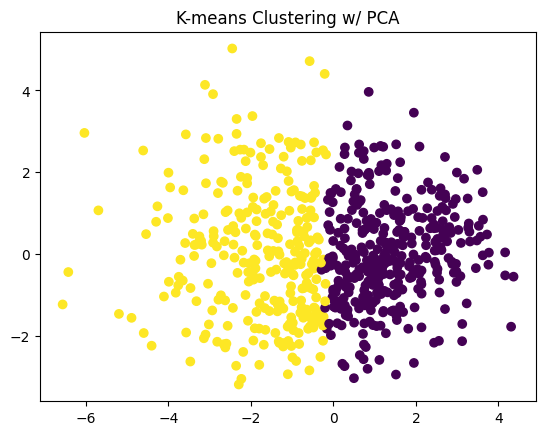

In [26]:
#Reducing the dimensionality to visualise it
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
#Plotting the PCA
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_df['Cluster'], cmap='viridis')
plt.title('K-means Clustering w/ PCA')
plt.show()

In [27]:
# Save to pickle for gradio
with open('../gradio/kmc_gradio/models/cluster_df.pkl', 'wb') as f:
    pickle.dump(cluster_df, f)

with open('../gradio/kmc_gradio/models/kmc_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

### **Gradio**

#### **K-Means Clustering**

In [29]:
kmc_gradio.make_gradio(cluster_df, kmeans)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
c:\Users\matth\anaconda3\envs\ics5110\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KMeans was fitted without

Keyboard interruption in main thread... closing server.
